Epidemic models
---

We have mentioned that epidemic models are one useful real-world application of social network analytics. Here's a simple example of epidemic modelling.

It is similar to the information-flow model. Each node has a state, which is
0 for normal nodes, or >0 if infected, with the integer value giving the
time since infection, or -1 for dead nodes. A node dies after an
incubation period $t_i$. An infected node, while alive, has a probability $p$ of infecting each of its neighbours, at each time-step. We model this as an outgoing message. 


In [13]:
from pregel import Vertex, Pregel
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
# try other values of n and m
n = 1000 # number of nodes
m = 20 # number of edges per node
p = 0.1 # probability of acquiring infection from a single neighbour
i = 1 # number of nodes initially infected
ti = 1 # incubation time: t time-steps after infection, the individual dies
nsteps = 100 # how many time-steps to run

def epidemic_main():
    vertices = [EpidemicVertex(j, [], [], [])
                for j in range(n)]
    create_edges(vertices)
    return epidemic_pregel(vertices)

def create_edges(vertices):
    """Generates some randomly chosen in- and out-going edges from each
    vertex in vertices with random weights.
    """
    for v in vertices:
        v.out_vertices = random.sample(vertices, m)

def epidemic_stats(vertices):
    superstep = vertices[0].superstep
    n = len(vertices)
    palive = sum(v.value >= 0 for v in vertices) / float(n)
    pinfected = sum(v.value > 0 for v in vertices) / float(n)
    return superstep, palive, pinfected

def epidemic_pregel(vertices):
    """Simulates an epidemic using Pregel."""
    p = Pregel(vertices,stats_fn=epidemic_stats)
    p.run()
    return p.data

class EpidemicVertex(Vertex):
    def update(self):
        if self.superstep == 0:
            # initialise
            if self.id == 0:
                # "patient zero"
                self.value = 1
            else:
                # healthy
                self.value = 0

        elif self.superstep < nsteps:
            if self.value == -1:
                # stop stop he's already dead
                self.active = False

            elif self.value > 0:
                # we are infected. no need to read incoming messages
                if self.value <= ti:
                    # stay infected
                    self.value += 1
                    # emit infection
                    self.outgoing_messages = [(v,1,1) for v in self.out_vertices]

                else:
                    # die
                    self.value = -1
                    self.active = False

            else:
                # we are not infected, so check incoming
                for v, w, msg in self.incoming_messages:
                    # every incoming message has a probability p of infecting this vertex
                    if random.random() < p:
                        self.value = 1

        else:
            self.active = False

In [40]:
def plot_v_time(ds, ylabel=""):
    for d in ds:
        d = np.array(d)
        plt.plot(d[:, 0], d[:, 1])
    plt.xlabel("Time")
    plt.ylabel(ylabel)

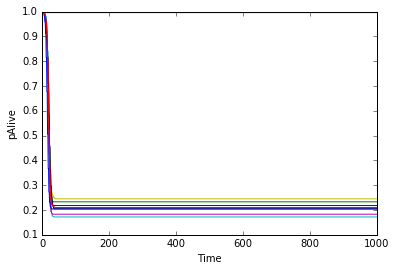

In [41]:
ds = []
for i in range(10):
    ds.append(epidemic_main())
plot_v_time(ds, "pAlive")

Exercises
---

1. For different values of $p$, $m$, $n$, run several times and observe the epidemic effect. Which values give a true epidemic (nearly all nodes die off), and which give a small local die-off?
2. Relate these values to the basic reproductive number $R_0$ (see notes and calculation below).
3. Plug in a NetworkX random graph model instead of the model used above. Try using different parameters in it. How does $R_0$ change, and how does the epidemic behaviour change?
4. Experiment with $t_i$. So far it has been set to $t_i=1$. The $R_0$ calculation would have to be different if a node has multiple "chances" to infect its neighbours.
5. Implement another algorithm from the Pregel paper: semi-clustering (difficult).

In [43]:
def R0(p, seq):
    # seq is a degree sequence
    n = len(seq)
    mean_d = 0.0
    mean_d_sq = 0.0
    for d in seq:
        mean_d += d
        mean_d_sq += d**2
    mean_d /= float(n)
    mean_d_sq /= float(n)
    return p * (mean_d_sq - mean_d) / mean_d